## Loading of Stringer spontaneous data

includes some visualizations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [2]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(f'./data/{fname}', "wb") as fid:
        fid.write(r.content)

In [4]:
# @title Data loading
dat = np.load('data/stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details. 
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other. 
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [5]:
# Now we have the data, let's make it nicer for me to work with and save in data/dataset.npy
dat_modified = {}
dat_modified['responses'] = dat['sresp']
dat_modified['run_speed'] = dat['run']
dat_modified['neuron_pos'] = dat['xyz']
dat_modified['pupil_area'] = dat['pupilArea']
dat_modified['pupil_pos'] = dat['pupilCOM']
dat_modified['behavior_embedding'] = dat['beh_svd_time']
dat_modified['movie_mask'] = dat['beh_svd_mask']
dat_modified['movie'] = np.transpose(dat['beh_svd_mask'] @ dat['beh_svd_time'].T, axes=[2, 0, 1])
dat_modified['info'] = f'responses: (11983 neurons x 7018 timebins) responses for each neuron at each time \n\
run_speed: (7018 timebins x 1) run speed for mouse at each time \n\
neuron_pos: (11983 neurons x 3) xyz position for each neuron \n\
pupil_area: (7018 timebins x 1) area of pupil for mouse at each time \n\
pupil_pos: (7018 timebins x 2) xy position of pupil for mouse at each time \n\
behavior_embedding: (7018 timebins x 1000) the behavior embedded in a vector size 1000 at each time \n\
movie: (7018 timebins x 240 x 320) the behavior movie at each time (corresponding to the embedding) \n\
movie_mask: (240 x 320 x 1) a mask to generate the movie, not important \n\
info: this text \n'    
import pickle
pickle.dump(dat_modified, open('data/dataset.pickle', 'wb'), protocol=4)

In [ ]:
def describe(arr):
    return f'size: {arr.shape}, min: {np.min(arr)}, max: {np.max(arr)}, mean: {np.mean(arr)}, std: {np.std(arr)}'
print(describe(dat['pupilArea']))

size: (7018, 1), min: 238.46559325534835, max: 2520.456081550447, mean: 902.2072883897861, std: 373.05096275870955


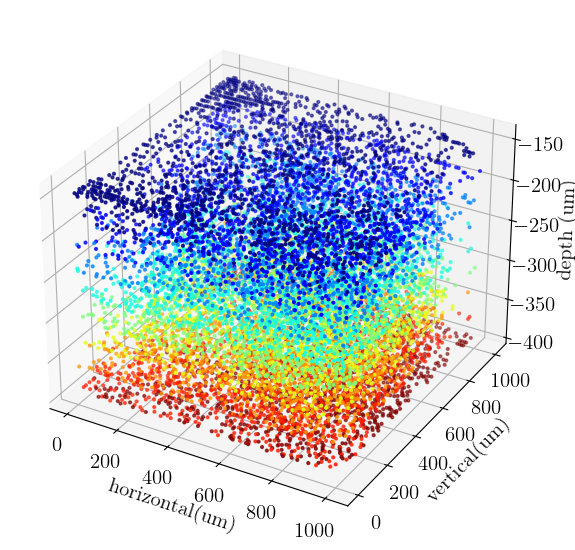

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.savefig('figures/all_data.png')
plt.show()

In [53]:
# @title Basic properties of behavioral data using plot and scatter
ax = plt.subplot(1, 5, 1)
plt.plot(dat['pupilArea'][:500, 0])
ax.set(xlabel='timepoints', ylabel='pupil area')

ax = plt.subplot(1, 5, 2)
plt.plot(dat['pupilCOM'][:500, :])
ax.set(xlabel='timepoints', ylabel='pupil XY position')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['beh_svd_time'][:500, 0])
ax.set(xlabel='timepoints', ylabel='face SVD #0')

ax = plt.subplot(1, 5, 4)
plt.plot(dat['beh_svd_time'][:500, 1])
ax.set(xlabel='timepoints', ylabel='face SVD #1')

ax = plt.subplot(1, 5, 5)
plt.scatter(dat['beh_svd_time'][:, 0], dat['beh_svd_time'][:, 1], s=1)
ax.set(xlabel='face SVD #0', ylabel='face SVD #1')

plt.savefig('figures/all_data_summary.png')
plt.show()

RuntimeError: latex was not able to process the following string:
b'face SVD #0'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error ../332364550f0e60f469bc049916e6a35d.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.24 (TeX Live 2022) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../332364550f0e60f469bc049916e6a35d.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-02-24>
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2022/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2022/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2022/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2022/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 332364550f0e60f469bc049916e6a35d.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in horizontal mode.
l.29 {\rmfamily face SVD #
                          0}%
No pages of output.
Transcript written on 332364550f0e60f469bc049916e6a35d.log.




<Figure size 2000x400 with 5 Axes>

In [ ]:
# @title take PCA after preparing data by z-score

Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components=200).fit_transform(Z)
print(Z.shape, X.shape)

(11983, 7018) (11983, 200)


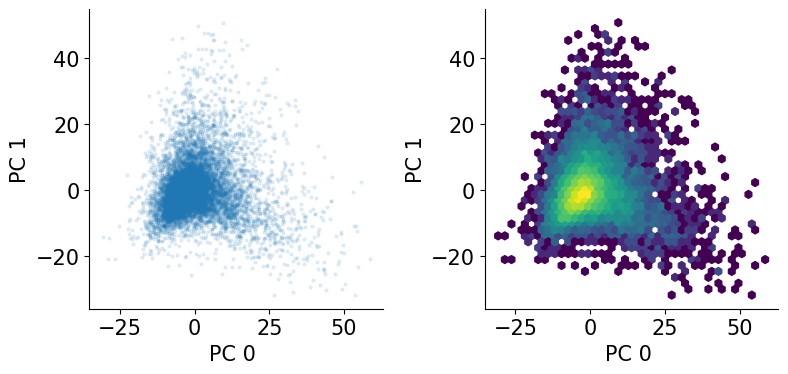

In [ ]:
# @title Plot PCs. Too many points, switch to logarithmic hexbin!
ax = plt.subplot(1, 5, 1)
plt.scatter(X[:, 0], X[:, 1], s=4, alpha=.1)
ax.set(xlabel='PC 0 ', ylabel='PC 1')

ax = plt.subplot(1, 5, 2)
plt.hexbin(X[:, 0], X[:, 1], gridsize=40, bins='log')
ax.set(xlabel='PC 0 ', ylabel='PC 1', alpha=.1)

plt.show()

In [ ]:
# @title run a manifold embedding algorithm (UMAP) in two or three dimensions.

ncomp = 1 # try 2, then try 3
xinit = 1 * zscore(X[:, :ncomp], axis=0)
embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=20,
             metric='correlation', transform_seed=42).fit_transform(X)

In [ ]:
embed = embed.flatten()
isort = np.argsort(embed)
RasterMap = uniform_filter1d(Z[isort, :], size=50, axis=0)
RasterMap = zscore(RasterMap[::10, :], axis=1)

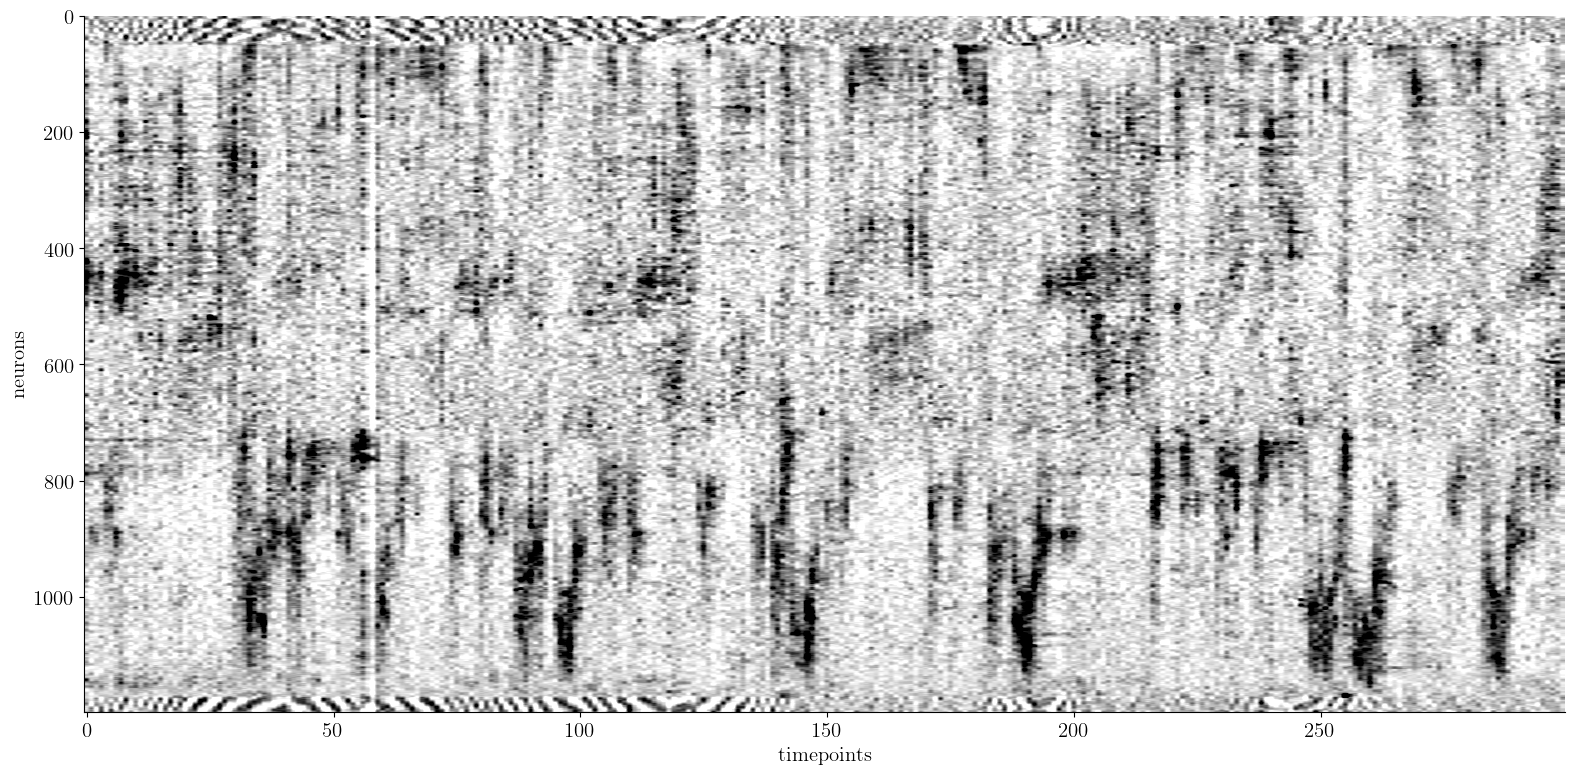

In [51]:
plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
trange = np.arange(1100, 1400)
plt.imshow(RasterMap[:, trange], vmax= 3, vmin=-1, aspect='auto', cmap='gray_r')
ax.set(xlabel='timepoints', ylabel='neurons')

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.savefig('figures/raster-map.png')
plt.show()

In [ ]:
# now sort with UMAP both the neuron axis and the timepoints axis, bin the sorted matrix and make a sorted Rastermap picture